# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 31, 11:59PM

### Name: Conor McGullam


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned hyper-parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import tensorflow.keras as keras
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

x_train, x_test = x_train / 255.0, x_test / 255.0

2023-03-31 20:13:08.661145: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 20:13:08.705005: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 20:13:08.880248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 20:13:08.881440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 20:13:09.817343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    y_vec = np.zeros((y.shape[0], num_class))
    for i in range(len(y)):
        y_vec[i][int(y[i])] = 1
    return y_vec
        

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 1)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 1)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
from tensorflow.keras import models, layers, losses

In [5]:
# Build the model
cnn = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid',input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2),strides=1),
    layers.Conv2D(64, kernel_size=(4, 4), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2),strides=1),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

2023-03-31 20:13:41.253468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-31 20:13:41.253738: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Define model optimizer and loss function
cnn.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
# Train the model and store model parameters/loss values
history = cnn.fit(x_tr, y_tr, epochs=10, 
                    validation_data=(x_val, y_val))

Epoch 1/10


/home/conor/.local/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 [==============================] - 151s 120ms/step - loss: 1.4876 - accuracy: 0.4650 - val_loss: 1.2422 - val_accuracy: 0.5641
Epoch 2/10
1250/1250 [==============================] - 159s 127ms/step - loss: 1.1233 - accuracy: 0.6024 - val_loss: 1.1331 - val_accuracy: 0.6013
Epoch 3/10
1250/1250 [==============================] - 154s 123ms/step - loss: 0.9291 - accuracy: 0.6717 - val_loss: 1.0836 - val_accuracy: 0.6195
Epoch 4/10
1250/1250 [==============================] - 153s 122ms/step - loss: 0.7588 - accuracy: 0.7332 - val_loss: 1.0490 - val_accuracy: 0.6443
Epoch 5/10
1250/1250 [==============================] - 152s 122ms/step - loss: 0.6023 - accuracy: 0.7876 - val_loss: 1.1371 - val_accuracy: 0.6423
Epoch 6/10
1250/1250 [==============================] - 154s 123ms/step - loss: 0.4499 - accuracy: 0.8425 - val_loss: 1.3461 - val_accuracy: 0.6129
Epoch 7/10
1250/1250 [==============================] - 155s 124ms/step - loss: 0.3205 - accuracy: 0.8892 - val_loss: 1.485

## 3. Plot the training and validation loss curve versus epochs. (5 points)

In [8]:
import matplotlib.pyplot as plt

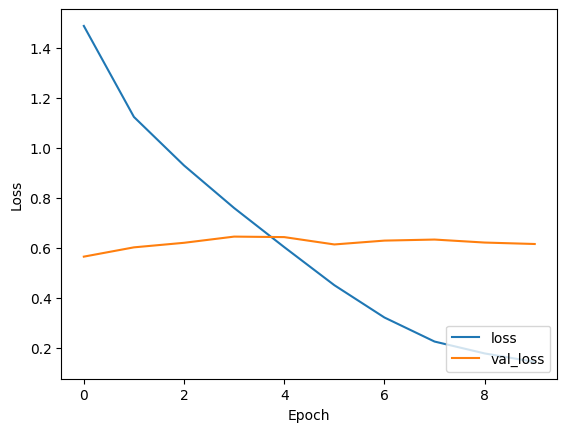

In [9]:
# Plot the loss curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [10]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
cnn.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
#<Train your model on the entire training set (50K samples)>
history2 = cnn.fit(x_train, y_train, epochs=10)

Epoch 1/10


/home/conor/.local/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 200s 127ms/step - loss: 0.4653 - accuracy: 0.8772
Epoch 2/10
1563/1563 [==============================] - 200s 128ms/step - loss: 0.2588 - accuracy: 0.9219
Epoch 3/10
1563/1563 [==============================] - 201s 128ms/step - loss: 0.1680 - accuracy: 0.9456
Epoch 4/10
1563/1563 [==============================] - 201s 129ms/step - loss: 0.1296 - accuracy: 0.9568
Epoch 5/10
1563/1563 [==============================] - 202s 129ms/step - loss: 0.1143 - accuracy: 0.9622
Epoch 6/10
1563/1563 [==============================] - 201s 129ms/step - loss: 0.0988 - accuracy: 0.9677
Epoch 7/10
1563/1563 [==============================] - 204s 130ms/step - loss: 0.0878 - accuracy: 0.9700
Epoch 8/10
1563/1563 [==============================] - 202s 129ms/step - loss: 0.0796 - accuracy: 0.9731
Epoch 9/10
1563/1563 [==============================] - 206s 132ms/step - loss: 0.0838 - accuracy: 0.9728
Epoch 10/10
1563/1563 [==============================] - 

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [12]:
# Evaluate your model performance (testing accuracy) on testing data.
test_loss, test_acc = cnn.evaluate(x_test,  y_test, verbose=2)
print(test_loss, test_acc)

313/313 - 4s - loss: 3.1963 - accuracy: 0.6258 - 4s/epoch - 11ms/step
3.1963143348693848 0.6258000135421753


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

In [14]:
cnn2 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid', input_shape=(32,32,3)),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])
cnn3 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid', input_shape=(32,32,3)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid', input_shape=(32,32,3)),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

In [15]:
cnn2.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn3.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
history3 = cnn2.fit(x_tr, y_tr, epochs=10, validation_data=(x_val, y_val))
history4 = cnn3.fit(x_tr, y_tr, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 18s 14ms/step - loss: 1.6698 - accuracy: 0.4161 - val_loss: 1.4441 - val_accuracy: 0.4951
Epoch 2/10
1250/1250 [==============================] - 17s 13ms/step - loss: 1.2455 - accuracy: 0.5596 - val_loss: 1.5099 - val_accuracy: 0.4904
Epoch 3/10
1250/1250 [==============================] - 17s 13ms/step - loss: 1.0822 - accuracy: 0.6195 - val_loss: 1.0407 - val_accuracy: 0.6361
Epoch 4/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.9925 - accuracy: 0.6521 - val_loss: 1.3743 - val_accuracy: 0.5712
Epoch 5/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9129 - accuracy: 0.6785 - val_loss: 0.8905 - val_accuracy: 0.6907
Epoch 6/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.8491 - accuracy: 0.7035 - val_loss: 0.8528 - val_accuracy: 0.7056
Epoch 7/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.8005 - accuracy: 0.7190 - val_loss: 0.8616 -

In [17]:
test_loss2, test_acc2 = cnn2.evaluate(x_test,  y_test, verbose=2)
test_loss3, test_acc3 = cnn3.evaluate(x_test,  y_test, verbose=2)
print(test_loss2, test_acc2)
print(test_loss3, test_acc3)

313/313 - 1s - loss: 0.8068 - accuracy: 0.7226 - 1s/epoch - 4ms/step
313/313 - 2s - loss: 0.6984 - accuracy: 0.7598 - 2s/epoch - 5ms/step
0.8067994713783264 0.722599983215332
0.6984467506408691 0.7598000168800354
